## Holder analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')

df_holders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   token_address                               2123 non-null   object 
 1   chain                                       2123 non-null   object 
 2   token_name                                  2123 non-null   object 
 3   total_holders                               2123 non-null   int64  
 4   total_supply                                2115 non-null   object 
 5   total_circulating_supply                    2123 non-null   object 
 6   howmany_holders_exceeding_5_percent         2123 non-null   int64  
 7   total_top_10_balance                        2115 non-null   object 
 8   top10_percentage_of_total_supply            2115 non-null   float64
 9   top10_percentage_of_circulating_supply      2115 non-null   float64
 10  top_10_less_

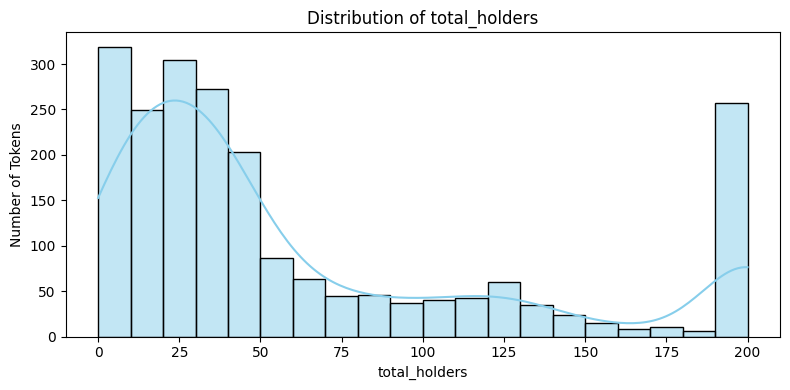

In [3]:
# 1. Distribution of total_holders

df_holders['total_supply'] = pd.to_numeric(df_holders['total_supply'], errors='coerce')

plt.figure(figsize=(8, 4))
plt.title(f'Distribution of total_holders')
sns.histplot(df_holders['total_holders'].dropna(), kde=True, bins=20, color='skyblue')
plt.xlabel('total_holders')
plt.ylabel('Number of Tokens')
plt.tight_layout()
plt.show()


C:\Users\Famiglia\AppData\Local\Temp\ipykernel_55744\4213750471.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Owner Category', y='Token Count', palette='Set2')


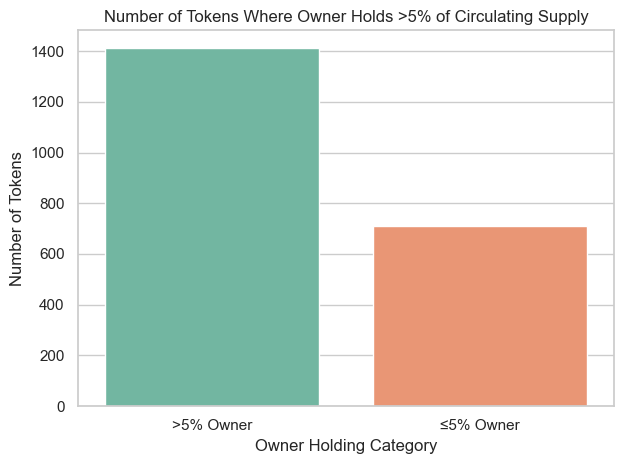

In [4]:
#Owner/creator wallet contains < 5% of circulating token supply
# Load data
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')  # has total_circulating_supply

# Merge holder list with contract info (to get owner)
df_merged = df_holders_list.merge(df_contracts[['token_address', 'owner']], on='token_address', how='left')

# Merge with circulating supply
df_merged = df_merged.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

# Normalize address case
df_merged['holder_address'] = df_merged['holder_address'].str.lower()
df_merged['owner'] = df_merged['owner'].str.lower()

# Filter to only owner rows
df_owner_holdings = df_merged[df_merged['holder_address'] == df_merged['owner']].copy()

# Calculate percent of total supply held by owner
df_owner_holdings['balance'] = pd.to_numeric(df_owner_holdings['balance'], errors='coerce')
df_owner_holdings['total_circulating_supply'] = pd.to_numeric(df_owner_holdings['total_circulating_supply'], errors='coerce')

# Clean bad data
df_owner_holdings = df_owner_holdings.dropna(subset=['balance', 'total_circulating_supply'])
df_owner_holdings = df_owner_holdings[df_owner_holdings['total_circulating_supply'] > 0]

# Calculate owner percentage
df_owner_holdings['owner_percent'] = (df_owner_holdings['balance'] / df_owner_holdings['total_circulating_supply']) * 100

# Determine which tokens exceed 5%
tokens_over_5 = df_owner_holdings[df_owner_holdings['owner_percent'] > 5]['token_address'].nunique()
total_tokens = df_contracts['token_address'].nunique()

# Prepare plot data
plot_df = pd.DataFrame({
    'Owner Category': ['>5% Owner', '≤5% Owner'],
    'Token Count': [tokens_over_5, total_tokens - tokens_over_5]
})

# Plot
sns.set(style="whitegrid")
sns.barplot(data=plot_df, x='Owner Category', y='Token Count', palette='Set2')
plt.title("Number of Tokens Where Owner Holds >5% of Circulating Supply")
plt.xlabel("Owner Holding Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_55744\2748027614.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Holder Category', y='Token Count', palette='coolwarm')


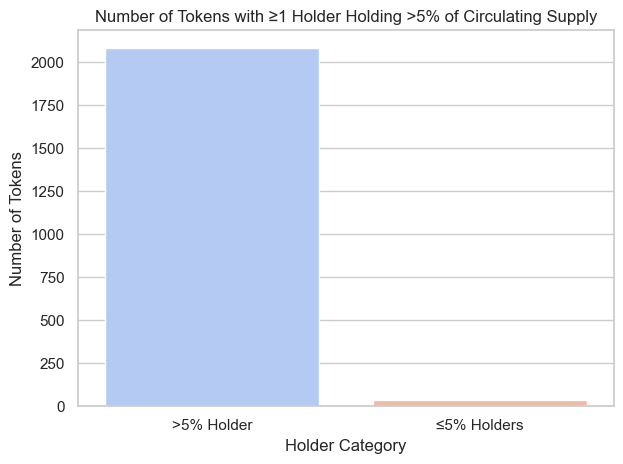

In [5]:
# Load data
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')  # has token_address, owner
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')  # has token_address, holder_address, balance
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')  # has token_address, total_circulating_supply

# Merge holders with total circulating supply
df_all = df_holders_list.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

# Convert to lowercase to standardize addresses
df_all['holder_address'] = df_all['holder_address'].str.lower()

# Convert balance and supply to numeric
df_all['balance'] = pd.to_numeric(df_all['balance'], errors='coerce')
df_all['total_circulating_supply'] = pd.to_numeric(df_all['total_circulating_supply'], errors='coerce')

# Drop rows with invalid or zero supply
df_all = df_all.dropna(subset=['balance', 'total_circulating_supply'])
df_all = df_all[df_all['total_circulating_supply'] > 0]

# Calculate holder's percent of supply
df_all['holder_percent'] = (df_all['balance'] / df_all['total_circulating_supply']) * 100

# Count unique tokens with at least one holder over 5%
tokens_with_holder_over_5 = df_all[df_all['holder_percent'] > 5]['token_address'].nunique()
total_tokens = df_all['token_address'].nunique()

# Prepare data for plotting
plot_df = pd.DataFrame({
    'Holder Category': ['>5% Holder', '≤5% Holders'],
    'Token Count': [tokens_with_holder_over_5, total_tokens - tokens_with_holder_over_5]
})

# Plot
sns.set(style="whitegrid")
sns.barplot(data=plot_df, x='Holder Category', y='Token Count', palette='coolwarm')
plt.title("Number of Tokens with ≥1 Holder Holding >5% of Circulating Supply")
plt.xlabel("Holder Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()

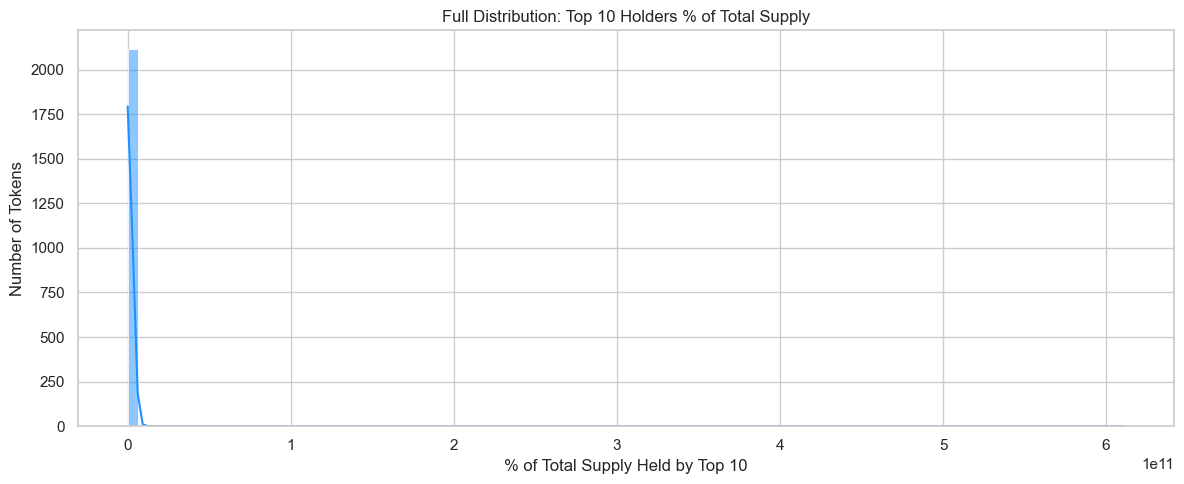

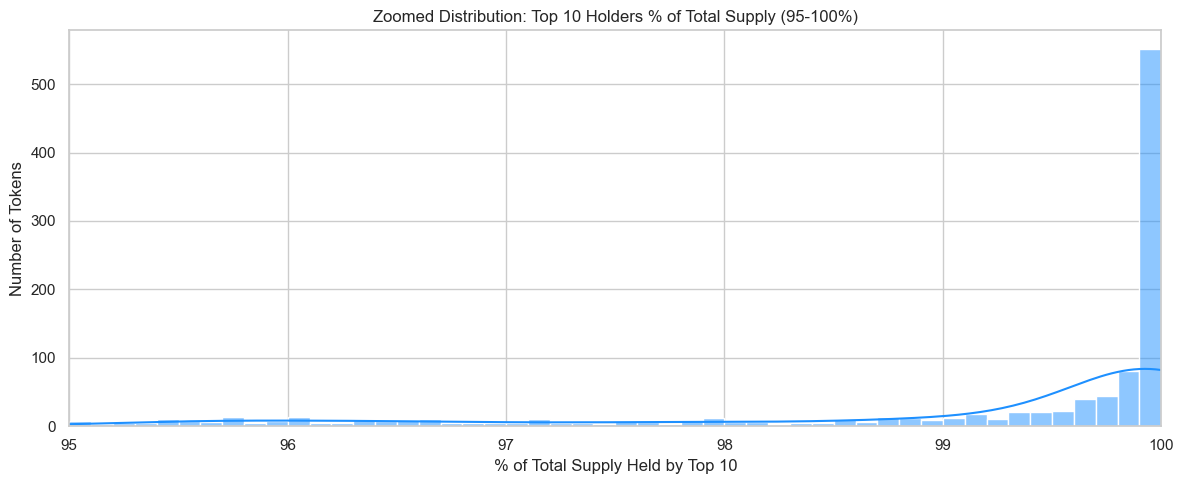

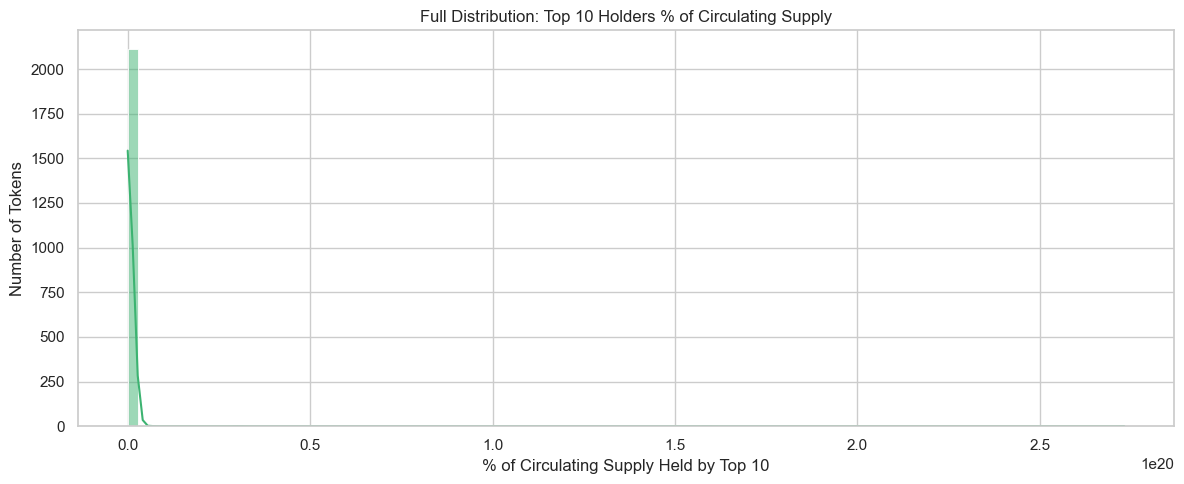

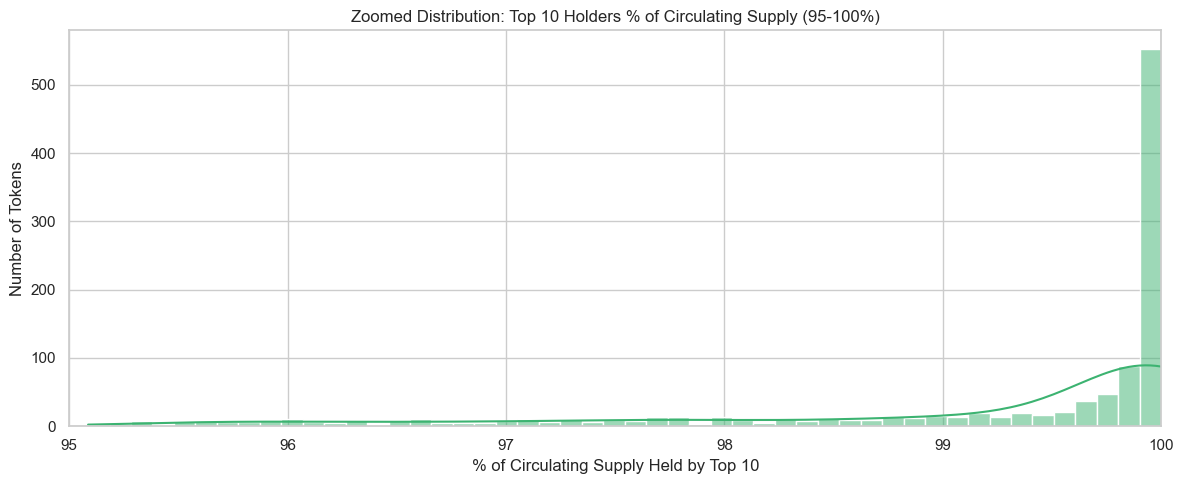

In [6]:
# Ensure columns are numeric (in case they were read as strings)
total_pct = pd.to_numeric(df_holders['top10_percentage_of_total_supply'], errors='coerce').dropna()
circ_pct = pd.to_numeric(df_holders['top10_percentage_of_circulating_supply'], errors='coerce').dropna()

# --- Plot full distribution for total supply percentage
plt.figure(figsize=(12, 5))
sns.histplot(total_pct, bins=100, kde=True, color='dodgerblue')
plt.title('Full Distribution: Top 10 Holders % of Total Supply')
plt.xlabel('% of Total Supply Held by Top 10')
plt.ylabel('Number of Tokens')
plt.tight_layout()
plt.show()

# --- Plot zoomed-in distribution for total supply percentage (95-100%)
plt.figure(figsize=(12, 5))
sns.histplot(total_pct[(total_pct >= 95) & (total_pct <= 100)], bins=50, kde=True, color='dodgerblue')
plt.title('Zoomed Distribution: Top 10 Holders % of Total Supply (95-100%)')
plt.xlabel('% of Total Supply Held by Top 10')
plt.ylabel('Number of Tokens')
plt.xlim(95, 100)
plt.tight_layout()
plt.show()

# --- Plot full distribution for circulating supply percentage
plt.figure(figsize=(12, 5))
sns.histplot(circ_pct, bins=100, kde=True, color='mediumseagreen')
plt.title('Full Distribution: Top 10 Holders % of Circulating Supply')
plt.xlabel('% of Circulating Supply Held by Top 10')
plt.ylabel('Number of Tokens')
plt.tight_layout()
plt.show()

# --- Plot zoomed-in distribution for circulating supply percentage (95-100%)
plt.figure(figsize=(12, 5))
sns.histplot(circ_pct[(circ_pct >= 95) & (circ_pct <= 100)], bins=50, kde=True, color='mediumseagreen')
plt.title('Zoomed Distribution: Top 10 Holders % of Circulating Supply (95-100%)')
plt.xlabel('% of Circulating Supply Held by Top 10')
plt.ylabel('Number of Tokens')
plt.xlim(95, 100)
plt.tight_layout()
plt.show()

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_55744\3386190986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_supply'] = pd.to_numeric(df_holders['total_supply'], errors='coerce')


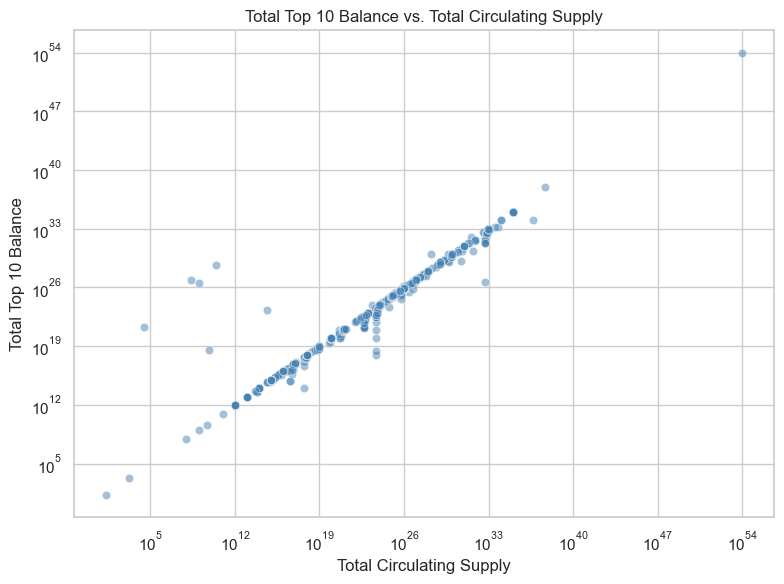

In [8]:
# Step 1: Convert to numeric
df_holders['total_top_10_balance'] = pd.to_numeric(df_holders['total_top_10_balance'], errors='coerce')
df_holders['total_circulating_supply'] = pd.to_numeric(df_holders['total_circulating_supply'], errors='coerce')

# Step 2: Filter out missing or invalid values
df = df_holders.dropna(subset=['total_top_10_balance', 'total_circulating_supply'])
df['total_supply'] = pd.to_numeric(df_holders['total_supply'], errors='coerce')
df = df[df['total_supply'] > 0]  # avoid divide-by-zero

# Step 3: Calculate ratio (float division)
df['top10_vs_circulating_ratio'] = df['total_top_10_balance'] / df['total_circulating_supply']


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='total_circulating_supply',
    y='total_top_10_balance',
    alpha=0.5,
    color='steelblue'
)
plt.title('Total Top 10 Balance vs. Total Circulating Supply')
plt.xlabel('Total Circulating Supply')
plt.ylabel('Total Top 10 Balance')
plt.xscale('log')  # Use log scale if the values vary widely
plt.yscale('log')
plt.tight_layout()
plt.show()

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_12048\1780360406.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=contracts, x='top_10_less_than_70_percent_of_total', palette='Set2')


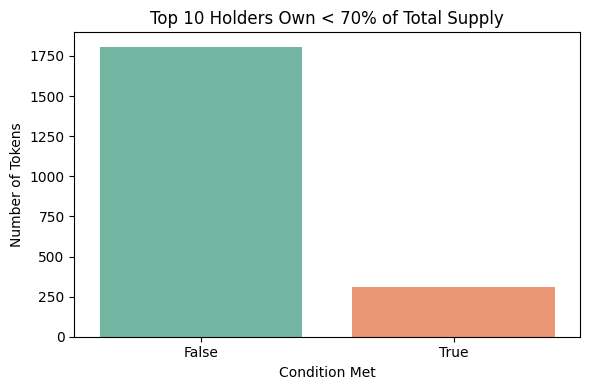

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_12048\1780360406.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=contracts, x='top_10_less_than_70_percent_of_circulating', palette='Set3')


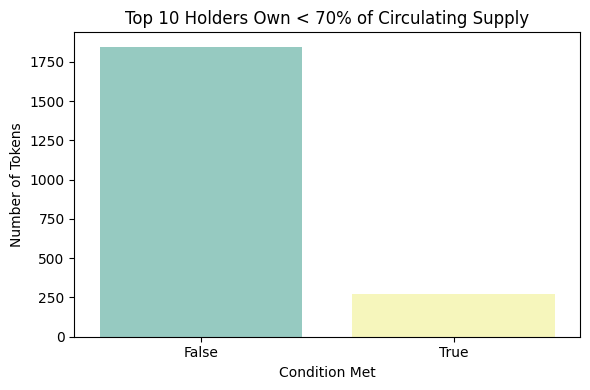

In [ ]:
# Plot 1: top_10_less_than_70_percent_of_total
plt.figure(figsize=(6, 4))
sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_total', palette='Set2')
plt.title('Top 10 Holders Own < 70% of Total Supply')
plt.xlabel('Condition Met')
plt.ylabel('Number of Tokens')
plt.xticks([0, 1], ['False', 'True'])
plt.tight_layout()
plt.show()

# Plot 2: top_10_less_than_70_percent_of_circulating
plt.figure(figsize=(6, 4))
sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_circulating', palette='Set3')
plt.title('Top 10 Holders Own < 70% of Circulating Supply')
plt.xlabel('Condition Met')
plt.ylabel('Number of Tokens')
plt.xticks([0, 1], ['False', 'True'])
plt.tight_layout()
plt.show()

## Holder List analysis